# Init functions and config

In [474]:
from functions.network_generation import erdos, barabasi_albert, focussed_assort_networks_gen
from functions.visualize import plot_timeseries, set_labels_and_titles
from functions.metrics import dos_neighbors
from functions.model import mainModel

import researchhelper.visualize.general_formatting as gf

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import FancyBboxPatch

import networkx as nx
import pandas as pd
import numpy as np
import json
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [475]:
with open("input/configs/main_config.json", "r") as f:
    conf = json.load(f)
conf["network_gen_fn"] = globals().get(conf["network_gen_fn"])
conf_path = f"{conf['network_gen_fn'].__name__}-{conf['e_samples']}es-{conf['n_per_group']}n-{conf['p_rel']}p"

point_dict = {
    "[1, 0, 0]": "Pure Cognitive",
    "[0, 1, 0]": "Pure Behavior",
    "[0, 0, 1]": "Pure Contagion",
    "[1.0, 0.0, 0.0]": "Pure Cognitive",
    "[0.0, 1.0, 0.0]": "Pure Behavior",
    "[0.0, 0.0, 1.0]": "Pure Contagion",
    "[0.5, 0.5, 0.0]": "Mixed Cognitive-Behavior",
    "[0.5, 0.0, 0.5]": "Mixed Cognitive-Contagion",
    "[0.0, 0.5, 0.5]": "Mixed Behavior-Contagion",
    "[0.5, 0.5, 0]": "Mixed Cognitive-Behavior",
    "[0.5, 0, 0.5]": "Mixed Cognitive-Contagion",
    "[0, 0.5, 0.5]": "Mixed Behavior-Contagion",
    "[0.8, 0.1, 0.1]": "Dominant Cognitive",
    "[0.1, 0.8, 0.1]": "Dominant Behavior",
    "[0.1, 0.1, 0.8]": "Dominant Contagion",
}

conf["points"] = [
    [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]],
    [[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]],
    [[0.5, 0.5, 0.0], [0.5, 0.0, 0.5], [0.0, 0.5, 0.5]],
]


# Answer questions

## Can we replicate the three degrees of influence (DOI)?


In [609]:
def get_DOS(G):
    e_links = {distance:[] for distance in range(1,5)}
    DOS = {}
    dn = dos_neighbors(G)
    for node in dn:
        for distance in dn[node]:
            for neighbor in dn[node][distance]:
                e_links[distance].append([G.nodes[node]["e"],G.nodes[neighbor]["e"]])
    
    for d in e_links:
        energy_links = np.array(e_links[d])

        if np.all(energy_links[:, 0] == energy_links[:, 0][0]) and np.all(
            energy_links[:, 1] == energy_links[:, 1][0]
        ):
            corrcoef = [[1, 1], [1, 1]]
        else:
            import warnings

            with warnings.catch_warnings():
                warnings.filterwarnings("error")
                try:
                    corrcoef = np.corrcoef(energy_links[:, 0], energy_links[:, 1])
                except Warning as e:
                    print("error found:", e)
                    print(energy_links)
                    corrcoef = [[np.nan, np.nan], [np.nan, np.nan]]
                    raise Exception("Energy links were off, check this!")
        DOS[d] = list(map(lambda x: list(np.around(x,5,)),corrcoef,))[0][1]
    return DOS

In [811]:
from networkx.exception import NetworkXError
conf["a_s"] = [-.8, -.6, -.4, -.2, 0, .2, .4, .6, .8]
dos_data = {}
for sim_dur in [10_000]:
    conf["sim_dur"] = sim_dur
    dos_data.setdefault(sim_dur, {})
    points = [[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]]
    for point in points:
        dos_data[sim_dur].setdefault(str(point), {})
        for a in conf["a_s"]:
            dos_data[sim_dur][str(point)].setdefault(a, {})

            model_path = f"p{'-'.join(str(np.round(p,2)) for p in point)}_b{conf['beta']}_sd{conf['sim_dur']}"
            dir_path = os.path.join(
                conf["base_path"], conf["raw_data"], conf["tt_path"], conf_path, str(a), model_path
            )
            files = os.listdir(dir_path)

            ps = {d:[] for d in range(1,5)}
            for file in files:
                try:
                    G = nx.read_gml(os.path.join(dir_path, file))
                except NetworkXError as e:
                    print(dir_path, file, e)

                for k,v in get_DOS(G).items():
                    ps[k].append(v)

            dos_data[sim_dur][str(point)][a] = ps

In [802]:
list(sns.color_palette("tab10"))

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

/var/folders/6n/qbch7vw93wb_sxfn1pz6069c0000gn/T/ipykernel_5518/2799409327.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


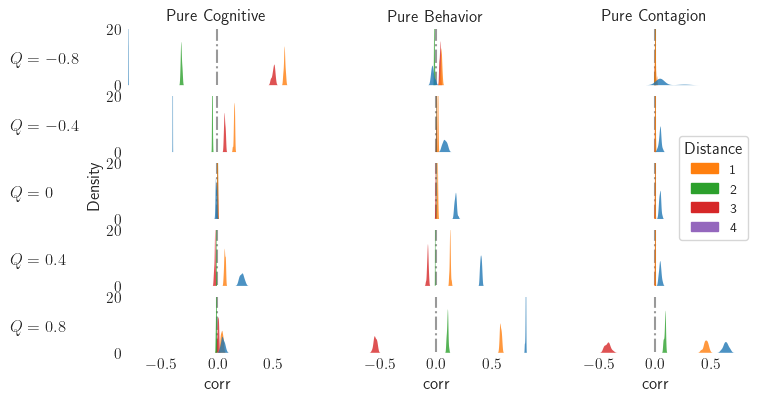

In [804]:
import seaborn as sns
cmap = list(sns.color_palette("tab10"))
a_s = [-.8, -.4, 0, .4, .8]
fig, ax = plt.subplots(len(a_s), 3, figsize=(8,4.2), sharex=True, sharey=True)
for yidx, point in enumerate(points):
   for idx, a in enumerate(a_s):
      df_data = {"corr": [], "distance":[]}
      for d in dos_data[10_000][str(point)][a]:
         df_data["corr"].extend(dos_data[10_000][str(point)][a][d])
         df_data["distance"].extend([d]*len(dos_data[10_000][str(point)][0.6][d]))
      df = pd.DataFrame(df_data)

      sns.kdeplot(
         data=df, x="corr", hue="distance",
         fill=True, common_norm=True, palette="tab10",
         alpha=0.8, linewidth=0, legend=False, zorder=1000, ax=ax[idx, yidx]
      )
      ax[idx, yidx].vlines(0, 0, 100, color="black", linestyle="-.", alpha=0.4,zorder=-100)
      ax[idx, yidx].set_ylabel(f"", fontsize=10, rotation=90, labelpad=10)
      ax[idx, yidx].set_yticks([0,20])
      ax[idx, yidx].set_xlim((-0.82,0.82))
      ax[idx, yidx].set_ylim((0,20))
      gf.set_frame(ax[idx, yidx], major_alpha=0)

for idx, title in enumerate(points):
   ax[0,idx].set_title(point_dict[str(title)])

patches = [mpatches.Patch(color=cmap[d], label=f"{d}") for d in range(1,5)]

ax[idx, yidx].set_ylabel(f"$Q={a}$", fontsize=10, rotation=90, labelpad=10)
plt.text(-5.1, 60, r"Density", fontsize=12, rotation=90, va="center")

for i, a in enumerate(a_s):
   plt.text(-5.8, 105-24*i, f"$Q={a}$", fontsize=12, rotation=0, va="center")

plt.legend(handles=patches, prop={'size': 10}, bbox_to_anchor=(1.05,4), title=r"Distance", title_fontsize=12)
plt.tight_layout()
plt.savefig("output/final_results/kde_plot.png", dpi=300, bbox_inches="tight")
plt.show()


### Correlation matrix


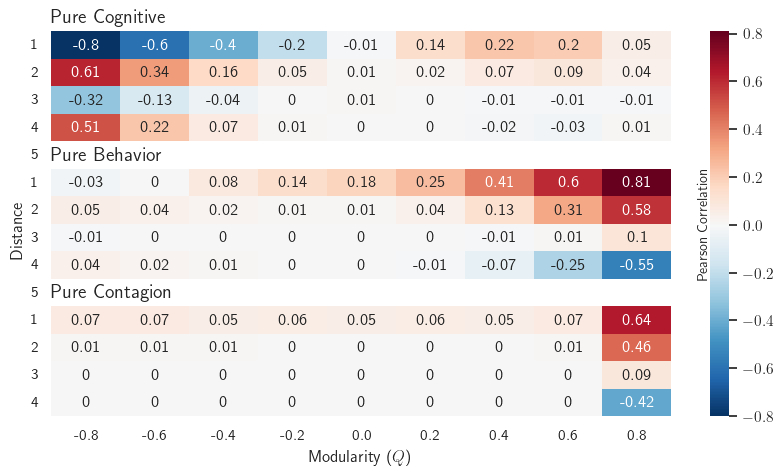

In [813]:
import seaborn as sns

def my_ceil(a, precision=0):
    return np.true_divide(np.ceil(a * 10**precision), 10**precision)

points = [[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]]
frames = []

for idx, point in enumerate(points):
    point = str(point)
    #/abs(np.mean(dos_data[10000][point][a][1]))
    d_dict = {a: [my_ceil(np.mean(dos_data[10000][point][a][d]), 2) for d in dos_data[10000][point][a]] for a in dos_data[10000][point]}
    if idx != len(points)-1:
        for k in d_dict.keys():
            d_dict[k].append(np.nan)
    frame = pd.DataFrame.from_dict(d_dict)
    # frame.replace(0, np.nan, inplace=True)
    frame.index = [f"{i}"for i in range(1, len(frame)+1)]
    frames.append(frame)

df = pd.concat(frames)
# df = df.round(3)
df += 0

fig, ax = plt.subplots(1,1, figsize=(10, 5))
hm = sns.heatmap(df, cmap="RdBu_r", center=0, annot=True, ax=ax)
hm.collections[0].colorbar.set_label('Pearson Correlation', labelpad=-55, fontsize=10)
plt.yticks(rotation=0)
ax.text(0, -0.3, point_dict[str(points[0])], fontsize=14)
ax.text(0, 4.7, point_dict[str(points[1])], fontsize=14)
ax.text(0, 9.7, point_dict[str(points[2])], fontsize=14)
ax.text(-0.6, 8.2, "Distance", fontsize=12, rotation=90)
ax.set_xlabel(r"Modularity ($Q$)", fontsize=12)

plt.savefig("./output/imgs/heatmap_3f.png", dpi=300, bbox_inches="tight")

plt.show()

### Correlation matrix start t0

In [740]:
from networkx.exception import NetworkXError
conf["a_s"] = [-.8, -.6, -.4, -.2, 0, .2, .4, .6, .8]
dos_data_init = {}

t0_graphs = f"input/t0_graphs/barabasi_albert-[0.2, 0.8]es-500n-11p"
for a in conf["a_s"]:
    dos_data_init.setdefault(a, {})

    dir_path = os.path.join(t0_graphs, f"{a}")
    files = os.listdir(dir_path)

    ps = {d:[] for d in range(1,5)}
    for file in files:
        try:
            G = nx.read_gml(os.path.join(dir_path, file))
        except NetworkXError as e:
            print(dir_path, file, e)

        for k,v in get_DOS(G).items():
            ps[k].append(v)

    dos_data_init[a] = ps

#### Show t0 correlations

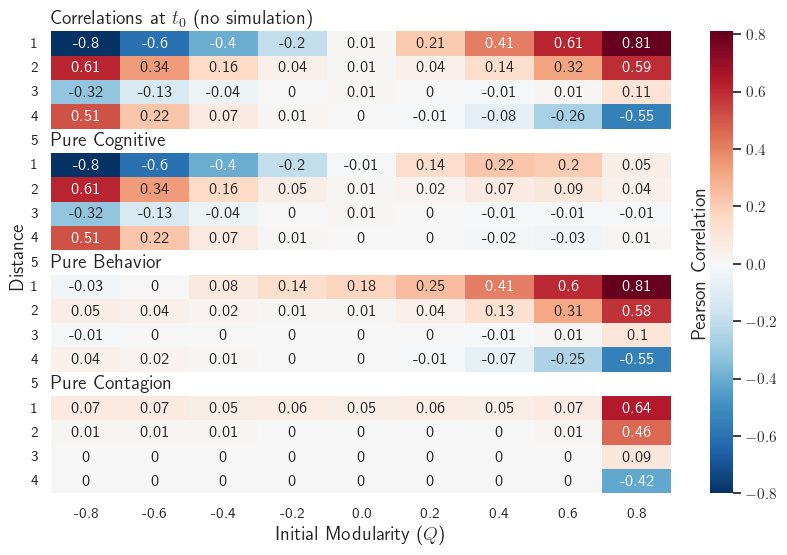

In [786]:
points = [[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]]
frames = []

d_dict = {a: [my_ceil(np.mean(dos_data_init[a][d]), 2) for d in dos_data_init[a]] for a in dos_data_init}
for k in d_dict.keys():
    d_dict[k].append(np.nan)
frame = pd.DataFrame.from_dict(d_dict)
# frame.replace(0, np.nan, inplace=True)
frame.index = [f"{i}"for i in range(1, len(frame)+1)]
frames.append(frame)

for idx, point in enumerate(points):
    point = str(point)
    #/abs(np.mean(dos_data[10000][point][a][1]))
    d_dict = {a: [my_ceil(np.mean(dos_data[10000][point][a][d]), 2) for d in dos_data[10000][point][a]] for a in dos_data[10000][point]}
    if idx != len(points)-1:
        for k in d_dict.keys():
            d_dict[k].append(np.nan)
    frame = pd.DataFrame.from_dict(d_dict)
    # frame.replace(0, np.nan, inplace=True)
    frame.index = [f"{i}"for i in range(1, len(frame)+1)]
    frames.append(frame)

df = pd.concat(frames)
# df = df.round(3)
df += 0

fig, ax = plt.subplots(1,1, figsize=(10, 6))
hm = sns.heatmap(df, cmap="RdBu_r", center=0, annot=True, ax=ax)
hm.collections[0].colorbar.set_label('Pearson Correlation', labelpad=-62, fontsize=14)
plt.yticks(rotation=0)
ax.text(0, -0.3, "Correlations at $t_0$ (no simulation)", fontsize=14)
ax.text(0, 4.7, point_dict[str(points[0])], fontsize=14)
ax.text(0, 9.7, point_dict[str(points[1])], fontsize=14)
ax.text(0, 14.7, point_dict[str(points[2])], fontsize=14)
ax.text(-0.6, 10.5, "Distance", fontsize=14, rotation=90)
ax.set_xlabel(r"Initial Modularity ($Q$)", fontsize=14)

plt.savefig("./output/imgs/heatmap_3f.png", dpi=300, bbox_inches="tight")

plt.show()

#### Subtracting correlations from t0

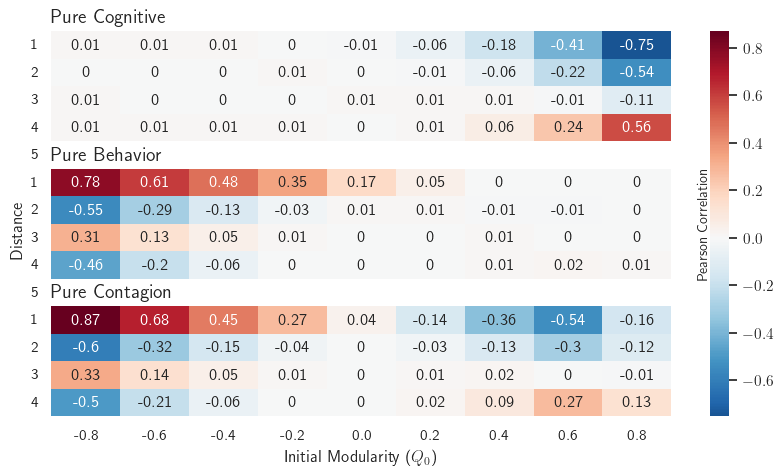

In [784]:
import seaborn as sns

def my_ceil(a, precision=0):
    return np.true_divide(np.ceil(a * 10**precision), 10**precision)

points = [[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]]
frames = []

for idx, point in enumerate(points):
    point = str(point)
    #/abs(np.mean(dos_data[10000][point][a][1]))
    d_dict = {a: [my_ceil(np.mean(dos_data[10000][point][a][d]) - np.mean(dos_data_init[a][d]), 2) for d in dos_data[10000][point][a]] for a in dos_data[10000][point]}
    if idx != len(points)-1:
        for k in d_dict.keys():
            d_dict[k].append(np.nan)
    frame = pd.DataFrame.from_dict(d_dict)
    # frame.replace(0, np.nan, inplace=True)
    frame.index = [f"{i}"for i in range(1, len(frame)+1)]
    frames.append(frame)

df = pd.concat(frames)
# df = df.round(3)
df += 0

fig, ax = plt.subplots(1,1, figsize=(10, 5))
hm = sns.heatmap(df, cmap="RdBu_r", center=0, annot=True, ax=ax)
hm.collections[0].colorbar.set_label('Pearson Correlation', labelpad=-55, fontsize=10)
plt.yticks(rotation=0)
ax.text(0, -0.3, point_dict[str(points[0])], fontsize=14)
ax.text(0, 4.7, point_dict[str(points[1])], fontsize=14)
ax.text(0, 9.7, point_dict[str(points[2])], fontsize=14)
ax.text(-0.6, 8.2, "Distance", fontsize=12, rotation=90)
ax.set_xlabel(r"Initial Modularity ($Q_0$)", fontsize=12)

plt.show()

### initial bar chart

{'[1.0, 0.0, 0.0]': [0.047132999999999994, 0.0390885, -0.012565499999999999, 0.004188], '[0.0, 1.0, 0.0]': [0.8031115, 0.5781375, 0.09990750000000001, -0.5505865], '[0.0, 0.0, 1.0]': [0.6348315, 0.454526, 0.08671799999999999, -0.428508]}
{'[1.0, 0.0, 0.0]': array([ 1.        ,  0.8293234 , -0.26659665,  0.08885494]), '[0.0, 1.0, 0.0]': array([ 1.        ,  0.71987202,  0.12440053, -0.6855667 ]), '[0.0, 0.0, 1.0]': array([ 1.        ,  0.71597896,  0.13660003, -0.67499486])}


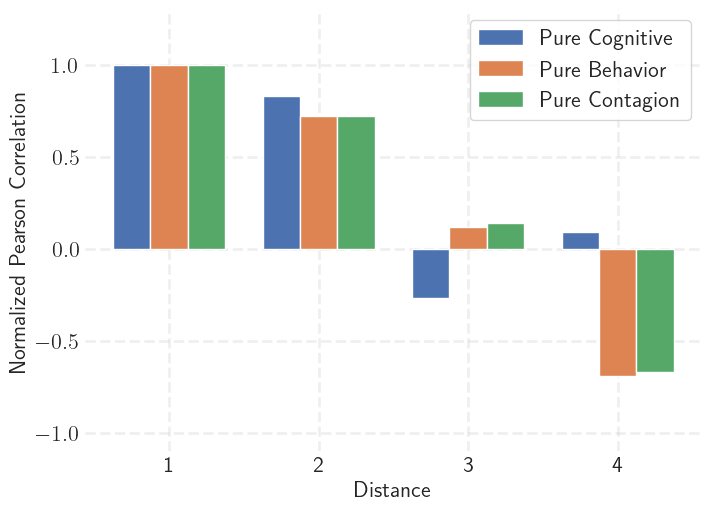

In [739]:
bar_data = dos_data[10000]
points = list(bar_data.keys())
distances = list(bar_data[points[0]][0.8].keys())
means = {p: [np.mean(bar_data[p][0.8][d])
             for d in bar_data[p][0.8]] for p in points}
print(means)
means = {p: means[p]/means[p][0] for p in means}
print(means)
stds = {p: [np.std(bar_data[p][0.8][d])
            for d in bar_data[p][0.8]] for p in points}

x = np.arange(len(distances))
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize=(7,5))

for attribute, measurement in means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(measurement, 2), width,
                   label=point_dict[attribute], zorder=100)
    # ax.bar_label(rects, padding=-10, color='white', fontsize=16, label_type='edge', fontweight='bold', zorder=110)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correlation of\nalignment')
ax.set_xticks(x + width, distances)

gf.set_legend(ax, "upper right", size=16)
ax.set_ylim(-1.1, 1.3)
gf.set_frame(ax, major_alpha=0.3, x_major_td=0)
set_labels_and_titles(ax, "", r"Distance", "Normalized Pearson Correlation", tick_size=16, label_size=16, title_size=18,)
plt.savefig("output/final_results/doi_over_pathways.png", dpi=300)
plt.show()

### What is the relationship between the pathways and DOI over different levels of homophily (modularity)?

#### Setup code

##### Setup data

###### Generate data

In [ ]:
from networkx.exception import NetworkXError
# conf["base_path"] = "output"
conf["a_s"] = [-.8, -.6, -.4, -.2, 0, .2, .4, .6, .8]
dos_data = {}
for sim_dur in [1000]:
    conf["sim_dur"] = sim_dur
    dos_data.setdefault(sim_dur, {})
    points = [[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]]
    # fig, ax = plt.subplots(1,1,figsize=(6,4))
    for point in points:
        dos_data[sim_dur].setdefault(str(point), {})
        for a in conf["a_s"]:
            dos_data[sim_dur][str(point)].setdefault(a, {})

            model_path = f"p{'-'.join(str(np.round(p,2)) for p in point)}_b{conf['beta']}_sd{conf['sim_dur']}"
            dir_path = os.path.join(
                conf["base_path"], conf["raw_data"], conf["tt_path"], conf_path, str(a), model_path
            )
            files = os.listdir(dir_path)

            ps = {d:[] for d in range(1,5)}
            for file in files:
                try:
                    G = nx.read_gml(os.path.join(dir_path, file))
                except NetworkXError as e:
                    print(dir_path, file, e)

                links = {distance:[] for distance in range(1,5)}
                dn = dos_neighbors(G)
                for node in dn:
                    for distance in dn[node]:
                        for neighbor in dn[node][distance]:
                            links[distance].append([G.nodes[node]["e"],G.nodes[neighbor]["e"]])
                
                for d in links:
                    energy_links = np.array(links[d])

                    if np.all(energy_links[:, 0] == energy_links[:, 0][0]) and np.all(
                        energy_links[:, 1] == energy_links[:, 1][0]
                    ):
                        corrcoef = [[1, 1], [1, 1]]
                    else:
                        import warnings

                        with warnings.catch_warnings():
                            warnings.filterwarnings("error")
                            try:
                                corrcoef = np.corrcoef(energy_links[:, 0], energy_links[:, 1])
                            except Warning as e:
                                print("error found:", e)
                                print(energy_links)
                                corrcoef = [[np.nan, np.nan], [np.nan, np.nan]]
                                raise Exception("Energy links were off, check this!")

                    ps[d].append(list(map(lambda x: list(np.around(x,5,)),corrcoef,))[0][1])

            dos_data[sim_dur][str(point)][a] = ps

KeyboardInterrupt: 

In [ ]:
with open("output/processed_data/json_data/DOS_data_noise.json", "w") as outfile:
    json.dump(dos_data, outfile)

###### Read data

In [809]:
# Opening JSON file
f = open('output/processed_data/json_data/DOS_p_data_v2_full.json')
    
# returns JSON object as 
# a dictionary
dos_data = json.load(f)

In [ ]:
dos_data

{'100': {'[1.0, 0.0, 0.0]': {'-0.8': {'1': [-0.80526,
     -0.80529,
     -0.80533,
     -0.80535,
     -0.80521,
     -0.80527,
     -0.80559,
     -0.80508,
     -0.80536,
     -0.80535,
     -0.80481,
     -0.80535,
     -0.80556,
     -0.8054,
     -0.80448,
     -0.80528,
     -0.80488,
     -0.80538,
     -0.80548,
     -0.80539],
    '2': [0.60193,
     0.60587,
     0.60043,
     0.58907,
     0.6063,
     0.61371,
     0.60866,
     0.59253,
     0.59786,
     0.61603,
     0.60525,
     0.59056,
     0.59689,
     0.60441,
     0.60268,
     0.61162,
     0.60338,
     0.60068,
     0.60769,
     0.60031],
    '3': [-0.32649,
     -0.3309,
     -0.32429,
     -0.31841,
     -0.32971,
     -0.33604,
     -0.33113,
     -0.3141,
     -0.32382,
     -0.33622,
     -0.32291,
     -0.31694,
     -0.31998,
     -0.33058,
     -0.32759,
     -0.33162,
     -0.33166,
     -0.32628,
     -0.32702,
     -0.32905],
    '4': [0.5185,
     0.5113,
     0.49403,
     0.49793,
     0.50868,

##### Plot mDOI over modularity for each simulation time per plot, plot per point

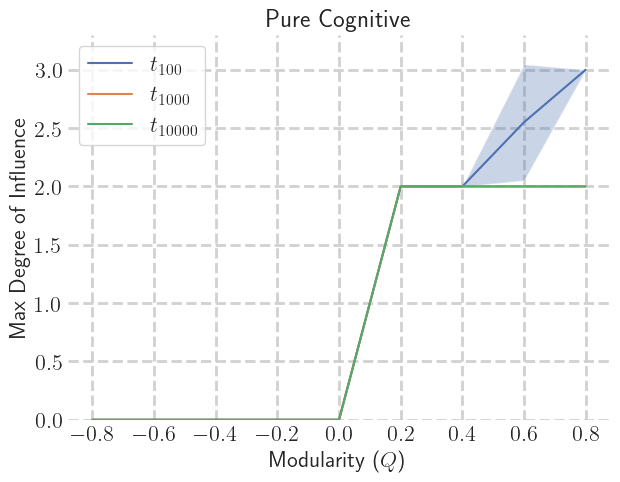

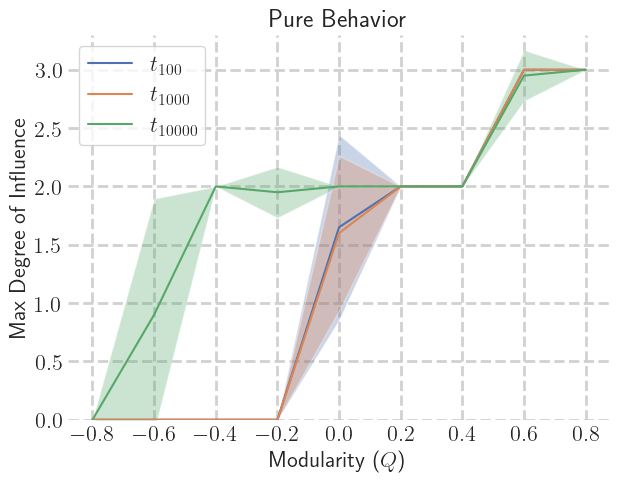

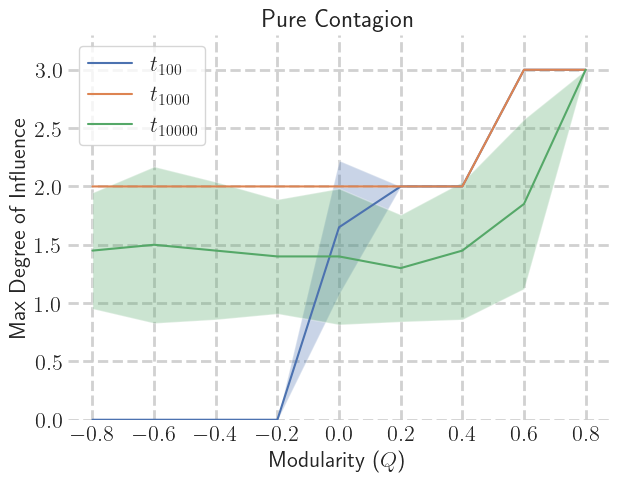

In [807]:
mDOI = {}
for sl in dos_data:
    for point in dos_data[sl]:
        mDOI.setdefault(point, {})
        mDOI[point].setdefault(sl, {})
        for a in dos_data[sl][point]:
            mDOI[point][sl].setdefault(a, [])
            df = pd.DataFrame(dos_data[sl][point][a]).T
            mDOIs = [int(df[df[col] <= 0].index[0]) for col in df]
            mDOI[point][sl][a] = mDOIs

for point in mDOI:
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    for sl in mDOI[point]:
        x = [float(k) for k in mDOI[point][sl].keys()]
        x.sort()
        means = np.array([np.mean(mDOI[point][sl][m])-1 for m in mDOI[point][sl]])
        stds = np.array([np.std(mDOI[point][sl][m]) for m in mDOI[point][sl]])
        ax.plot(x, means, label=rf"$t_{{{sl}}}$")
        ax.fill_between(x, means-stds, means+stds, alpha=0.3)
    gf.set_frame(ax=ax)
    set_labels_and_titles(
        ax=ax,
        title=f"{point_dict[point]}",
        xlabel=r"Modularity ($Q$)",
        ylabel=r"Max Degree of Influence",
        tick_size=16,
        label_size=16,
        title_size=18,
    )
    ax.set_ylim(0,3.3)
    gf.set_legend(ax, "upper left", size=16)
    plt.savefig(f"output/final_results/dos_degree_{point_dict[point].replace(' ', '_')}_over_time_pc.png", dpi=300)
    plt.show()

##### Plot mDOI over modularity for each point per plot, plot per simulation time

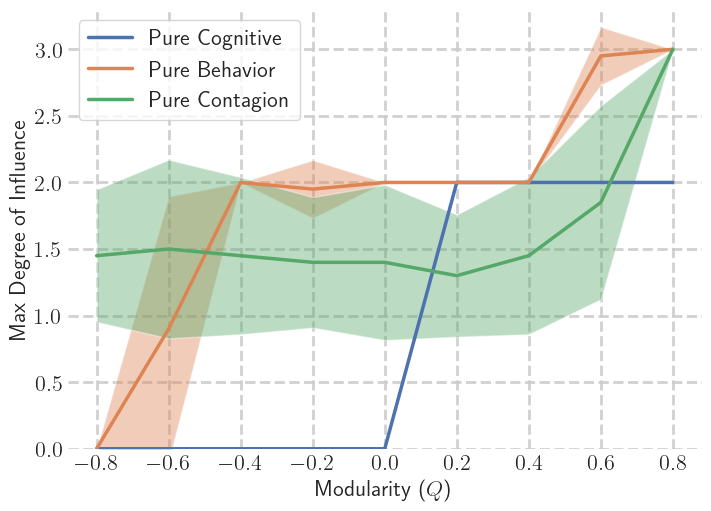

In [791]:
mDOI = {}
for sl in dos_data:
    mDOI.setdefault(sl, {})
    for point in dos_data[sl]:
        mDOI[sl].setdefault(point, {})
        for a in dos_data[sl][point]:
            mDOI[sl][point].setdefault(a, [])
            # for sim in range(len(dos_data[sl][point][a][1])):
            #     degree = 0
            #     for d in dos_data[sl][point][a]:
            #         if dos_data[sl][point][a][d][sim] <= 0:
            #             print(dos_data[sl][point][a][d][sim], d)
            #             degree = d
            #             continue
            df = pd.DataFrame(dos_data[sl][point][a]).T
            # df = df.round(2)
            mDOIs = [int(df[df[col] <= 0].index[0]) for col in df]
            mDOI[sl][point][a] = mDOIs

for sl in mDOI:
    fig, ax = plt.subplots(1,1,figsize=(7,5),layout='constrained',)
    for point in mDOI[sl]:
        x = list(mDOI[sl][point].keys())
        x.sort()
        means = np.array([np.mean(mDOI[sl][point][m])-1 for m in mDOI[sl][point]])
        stds = np.array([np.std(mDOI[sl][point][m]) for m in mDOI[sl][point]])
        ax.plot(x, means, label=point_dict[point], linewidth=2.5)
        ax.fill_between(x, means-stds, means+stds, alpha=0.4)
    gf.set_frame(ax=ax)
    set_labels_and_titles(
        ax=ax,
        title=f"",
        xlabel=r"Modularity ($Q$)",
        ylabel=r"Max Degree of Influence",
        tick_size=16,
        label_size=16,
        title_size=18,
    )
    ax.set_ylim(0,3.3)
    gf.set_legend(ax, "upper left", size=16)
    # plt.savefig(f"output/final_results/dos_degree_{sl}_pc.png", dpi=300)
    plt.show()

## What are the energy dynamics over time?
Over modularities, per subpopulation.


TypeError: 'float' object is not iterable

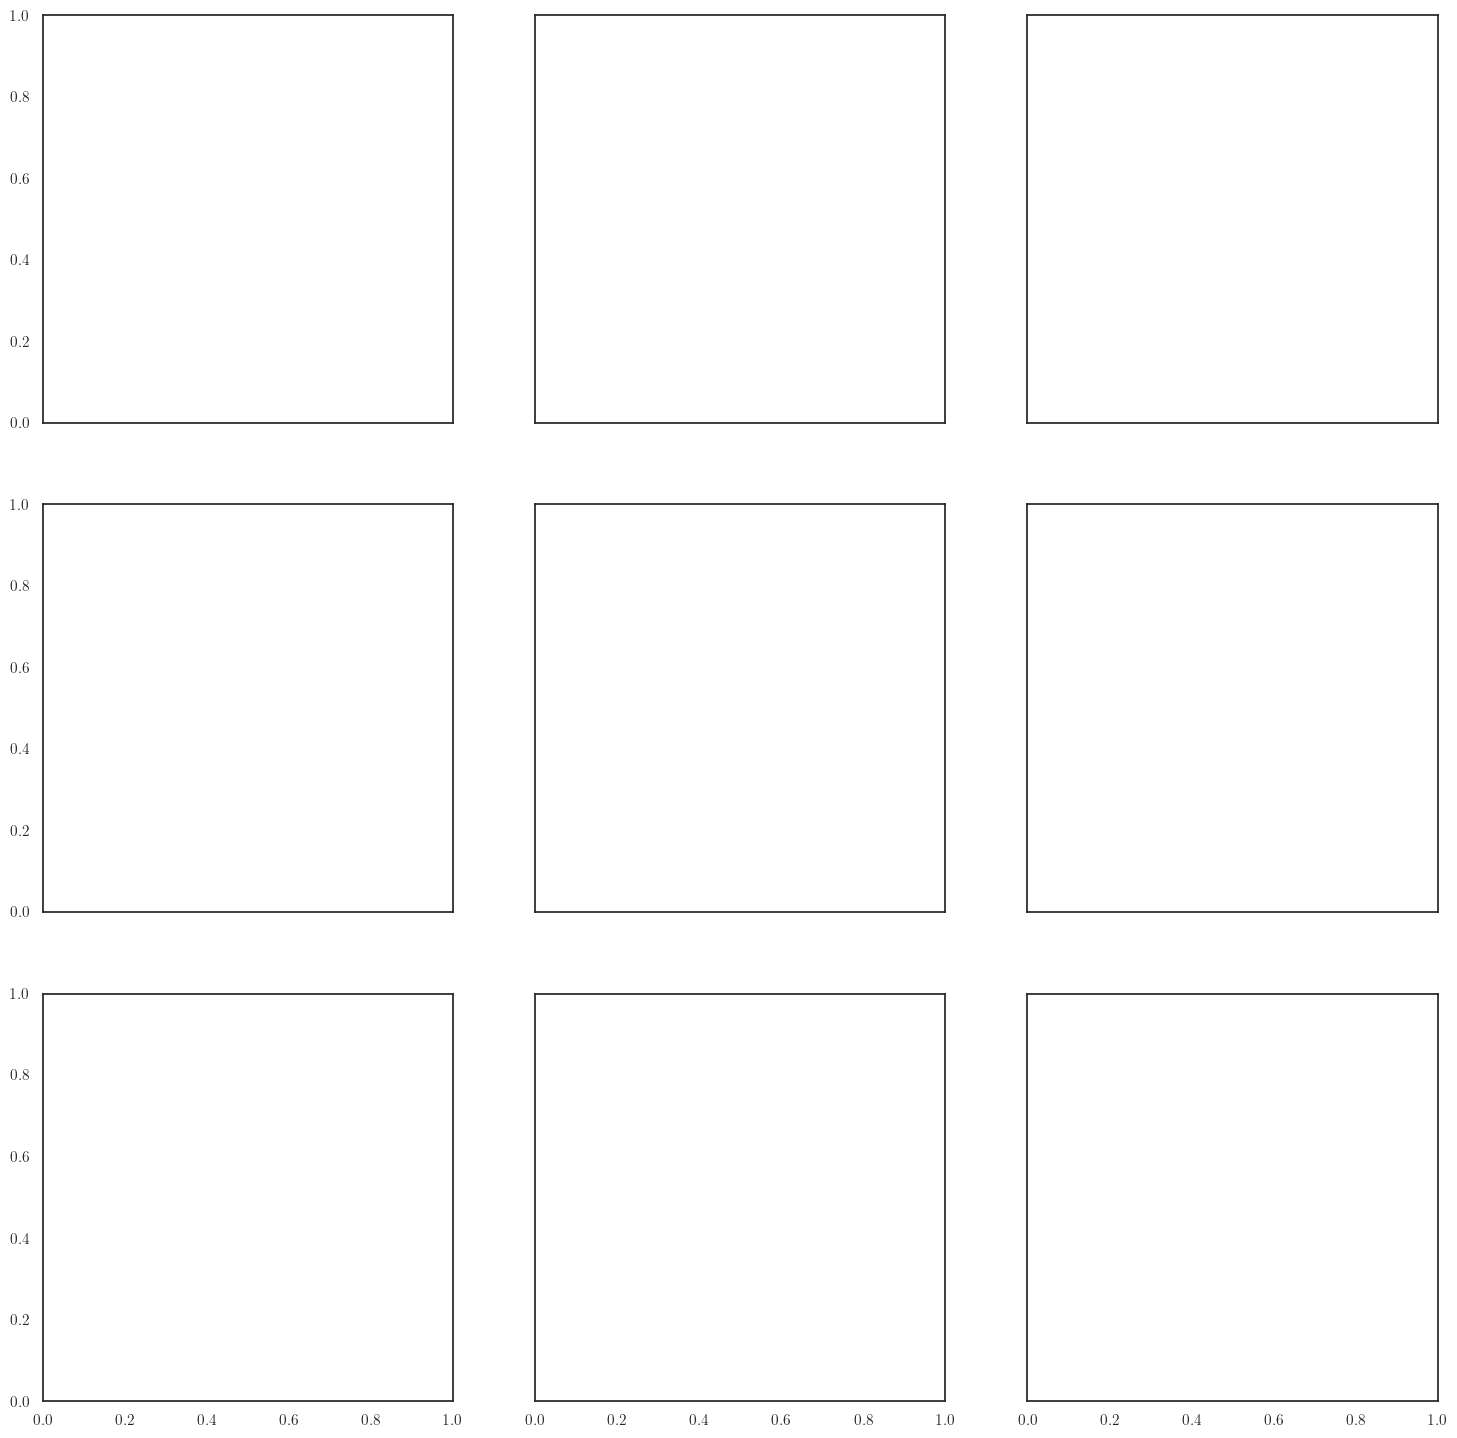

In [814]:
fig, ax = plt.subplots(
    len(conf["points"]),
    len(conf["points"][0]),
    figsize=(6 * len(conf["points"][0]), 6 * len(conf["points"])),
    sharex=True,
    sharey=True
)

cmap = plt.get_cmap("Spectral")
norm = mcolors.Normalize(vmin=-1, vmax=1)
# fig.patch.set_facecolor('white')
for row_id, row in enumerate(conf["points"]):
    for column_id, point in enumerate(row):
        model_path = f"p{'-'.join(str(np.round(p,2)) for p in point)}_b{conf['beta']}_sd{10000}"

        patches = []
        for a in conf["a_s"]:
            dyn_data_path = os.path.join(
                conf["base_path"], conf["raw_data"], conf["dyn_path"], conf_path, str(a), model_path
            )
            try:
                files = os.listdir(dyn_data_path)
                data_files = {}

                for idx, file in enumerate(files):
                    # Opening JSON file
                    with open(os.path.join(dyn_data_path, file), "r") as f:
                        # returns JSON object as
                        # a dictionary
                        data_files[idx] = json.load(f)

                non_lonely_mean = []
                lonely_mean = []
                non_lonely_std = []
                lonely_std = []

                for df in data_files:
                    non_lonely_mean.append(data_files[df]["non_lonely_mean"])
                    lonely_mean.append(data_files[df]["lonely_mean"])
                    non_lonely_std.append(data_files[df]["non_lonely_std"])
                    lonely_std.append(data_files[df]["lonely_std"])

                # Uncomment if you want variability between files
                plot_timeseries(ax[row_id, column_id], np.array(non_lonely_mean), a, cmap=cmap)
                plot_timeseries(ax[row_id, column_id], np.array(lonely_mean), a, cmap=cmap)

                # Uncomment if you want mean variability within simulations
                # plot_timeseries(ax[row_id, column_id], np.array(non_lonely_mean), a, data_std=np.array(non_lonely_std))
                # plot_timeseries(ax[row_id, column_id], np.array(lonely_mean), a, data_std=np.array(lonely_std))

                patches.append(mpatches.Patch(color=cmap(norm(a)), label=a))
            except FileNotFoundError as e:
                print(e)
            except ValueError as e:
                print(e)
            gf.set_frame(ax=ax[row_id, column_id])
            ax[row_id, column_id].set_box_aspect(1)
            set_labels_and_titles(
                ax=ax[row_id, column_id],
                title=f"{point_dict[str(point)]}",
                xlabel="Time",
                ylabel="Energy",
                tick_size=16,
                label_size=16,
                title_size=18,
            )

ax[1,2].legend(handles=patches, prop={'size': 16}, bbox_to_anchor=(1.01, .91), title=r"$Q_0$", title_fontsize=18)
plt.subplots_adjust(wspace=0.05, hspace=0.2)
plt.savefig("output/final_results/dyn_e.png", dpi=300)
plt.show()


### What are the proportions of agents changing energy with respect to their homophilic tag?

# Archived

## Degrees of influence explained

adding p=0.8


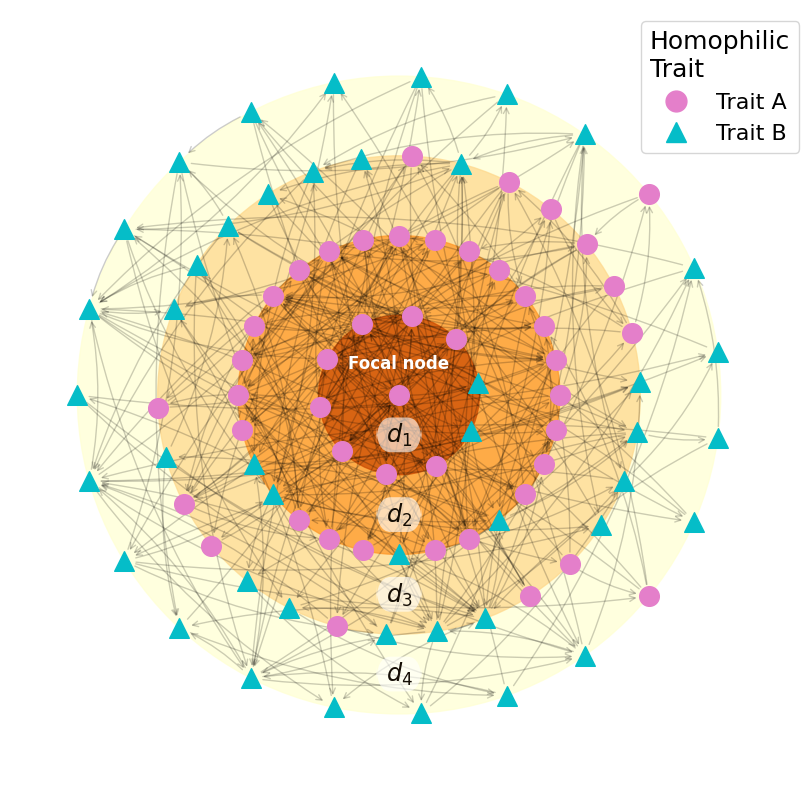

In [ ]:
def plot_fig(ax, G, pos, fn):
    # pos = nx.nx_agraph.graphviz_layout(G, prog="neato")
    # pos = nx.circular_layout(G)
    cmap = {0.2:"#E47FCA", 0.8:"#05BDC8"}
    colors = [cmap[G.nodes[node]["e"]] if node != fn else "white" for node in G.nodes]
    # shapes = {0:"o", 1:"^"}
    # shapes = ["o" if G.nodes[node]["e"] == 0.2 else "^" for node in G.nodes]

    groups = set([node[0] for node in G.nodes])    
    group_nodes = {g:[node for node in G.nodes if node[0] == g] for g in groups}
    subgraphs = {g: G.subgraph(group_nodes[g]) for g in group_nodes}
    fng = G.subgraph(fn)
    shapes = {"0":"o", "1":"^"}
    colors = {"0":"#E47FCA", "1":"#05BDC8"}
    # colors = {"0":"#74E882", "1":"#F7D8A1"}
    for sg in subgraphs:
        # colors = [cmap[subgraphs[sg].nodes[node]["e"]] if node != fn else "white" for node in subgraphs[sg].nodes]

        nx.draw_networkx_nodes(subgraphs[sg], pos=pos, node_color=colors[sg], node_shape=shapes[sg], node_size=200, ax=ax)

    # for sg in group_nodes:
    #     if fn in group_nodes[sg]:
    #         nx.draw_networkx_nodes(fng, pos=pos, node_color="white", node_shape=shapes[sg], node_size=50, ax=ax)
    # nx.draw_networkx_nodes(G, pos, node_color=colors,node_shape=shapes, node_size=200, ax=ax)
    nx.draw_networkx_edges(
        G,
        pos=pos,
        arrows=True,
        arrowstyle="->",
        connectionstyle="arc3,rad=0.1",
        edge_color="black",
        alpha=0.2,
        width=1,
        ax=ax,
    )
    # Remove box around figure
    for spine in ("top", "right", "bottom", "left"):
        ax.spines[spine].set_visible(False)

    label_a = {0.2:"Trait A", 0.8: "Trait B"}
    import matplotlib.lines as mlines
    legend = [mlines.Line2D([], [], color=cmap[a], label=label_a[a], marker=shapes[str(i)],linestyle='None', markersize=15) for i,a in enumerate(cmap)]
    
    return legend


Gs = focussed_assort_networks_gen([0.8], [0.2, 0.8], 50, 4)
G = Gs[0]
dn = dos_neighbors(G)
focal_node = sorted(G.in_degree, key=lambda x: x[1], reverse=True)[0][0]
shells = []
sg_nodes = []
for d in sorted(dn[focal_node].keys()):
    shells.append(dn[focal_node][d])
    for n in dn[focal_node][d]:
        sg_nodes.append(n)

sG = G.subgraph(sg_nodes)
pos = nx.shell_layout(sG, shells, center=(0, 0))
pos[focal_node] = np.array([0, 0])

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
colors = ['#bdd7e7', '#6baed6', '#3182bd', '#08519c']
colors = ['#ffffd4','#fed98e','#fe9929','#cc4c02']
for idx, c in enumerate(colors):
    ax.add_patch(plt.Circle((0, 0), 1-(idx*0.25), color=c, alpha=0.75))

patches = plot_fig(ax, sG, pos, focal_node)

for i in range(4):
    w, h = 0.15, 0.125
    ax.add_patch(FancyBboxPatch((-w/2,-((0.25+(i*0.25))-h/2)), w, h,
                        boxstyle="round,pad=-0.0040,rounding_size=0.045",
                        ec="none", fc="white", alpha=0.6,
                        mutation_aspect=2
                        ))
    ax.text(0,-(0.15+(i*0.25)), fr"$d_{i+1}$", fontsize="xx-large", horizontalalignment="center", color="#140D04")
ax.text(0,0.08, fr"Focal node", fontsize="large", fontweight="bold", horizontalalignment="center", color="white")


plt.legend(handles=patches, prop={'size': 16}, bbox_to_anchor=(0.8, .8), title="Homophilic\nTrait", title_fontsize=18)
plt.savefig("output/final_results/explanation_doi.png", dpi=300)


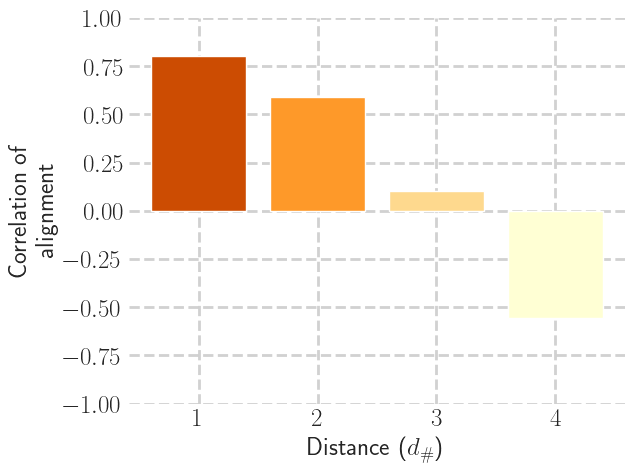

In [749]:
links = {distance:[] for distance in range(1,5)}
dn = dos_neighbors(G)
for node in dn:
    for distance in dn[node]:
        for neighbor in dn[node][distance]:
            links[distance].append([G.nodes[node]["e"],G.nodes[neighbor]["e"]])

corrs = []
for d in links:
    energy_links = np.array(links[d])

    if np.all(energy_links[:, 0] == energy_links[:, 0][0]) and np.all(
        energy_links[:, 1] == energy_links[:, 1][0]
    ):
        corrcoef = [[1, 1], [1, 1]]
    else:
        import warnings

        with warnings.catch_warnings():
            warnings.filterwarnings("error")
            try:
                corrcoef = np.corrcoef(energy_links[:, 0], energy_links[:, 1])
            except Warning as e:
                print("error found:", e)
                print(energy_links)
                corrcoef = [[np.nan, np.nan], [np.nan, np.nan]]
                raise Exception("Energy links were off, check this!")
    corrs.append(list(map(lambda x: list(np.around(x,5,)),corrcoef,))[0][1])

fig, ax = plt.subplots(1,1)
ax.bar(list(range(1,5)), corrs, zorder=100, color=colors[::-1])
gf.set_frame(ax)
ax.set_xticks([1,2,3,4])
set_labels_and_titles(ax, "", r"Distance ($d_\#$)", "Correlation of\nalignment", tick_size=18, label_size=18)
plt.tight_layout()
ax.set_ylim(-1, 1)
plt.savefig("output/final_results/explanation_doi_bars.png", dpi=300)

(-1.0, 1.0)

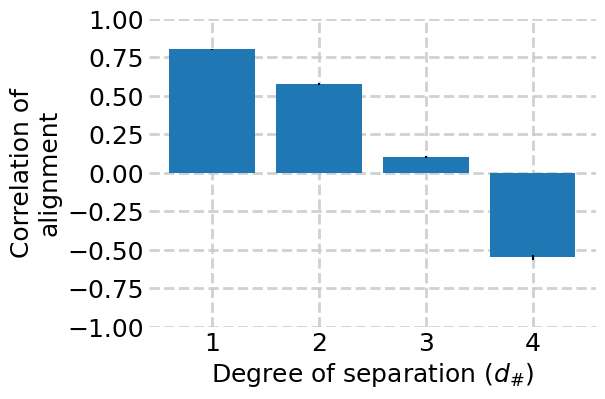

In [ ]:
means = [np.mean(ps[d]) for d in ps]
stds = [np.std(ps[d]) for d in ps]
fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.bar(list(range(1,5)), means, yerr=stds, zorder=100)
gf.set_frame(ax)
plt.xticks([1,2,3,4])
set_labels_and_titles(ax, "", r"Degree of separation ($d_\#$)", "Correlation of\nalignment", tick_size=18, label_size=18)
plt.tight_layout()
ax.set_ylim(-1, 1)
# plt.savefig("./results/dos_example.png", dpi=300)

## Ergodicity check

In [ ]:
defector_data = {}
for row, point in enumerate([[1.0,0.0,0.0], [0.0,1.0,0.0], [0.0,0.0,1.0]]):
    model_path = f"p{'-'.join(str(np.round(p,2)) for p in point)}_b{conf['beta']}_sd{10000}"
    defector_data.setdefault(str(point), {})
    for col, a in enumerate([-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8]):
        defector_data[str(point)].setdefault(a, {"ones":[], "zeros":[]})
        tt_assort_dir_path = os.path.join(
            conf["base_path"], conf["raw_data"], conf["tt_path"], conf_path, str(a), model_path
        )
        files = os.listdir(tt_assort_dir_path)
        for file in files:
            G = nx.read_gml(os.path.join(tt_assort_dir_path, file))
            zeros = np.array([G.nodes[node]["e"] for node in G.nodes if node[0] == "0"])
            ones = np.array([G.nodes[node]["e"] for node in G.nodes if node[0] == "1"])
            defector_data[str(point)][a]["zeros"].append(len(zeros[zeros>0.5])/len(zeros))
            defector_data[str(point)][a]["ones"].append(len(ones[ones<0.5])/len(ones))

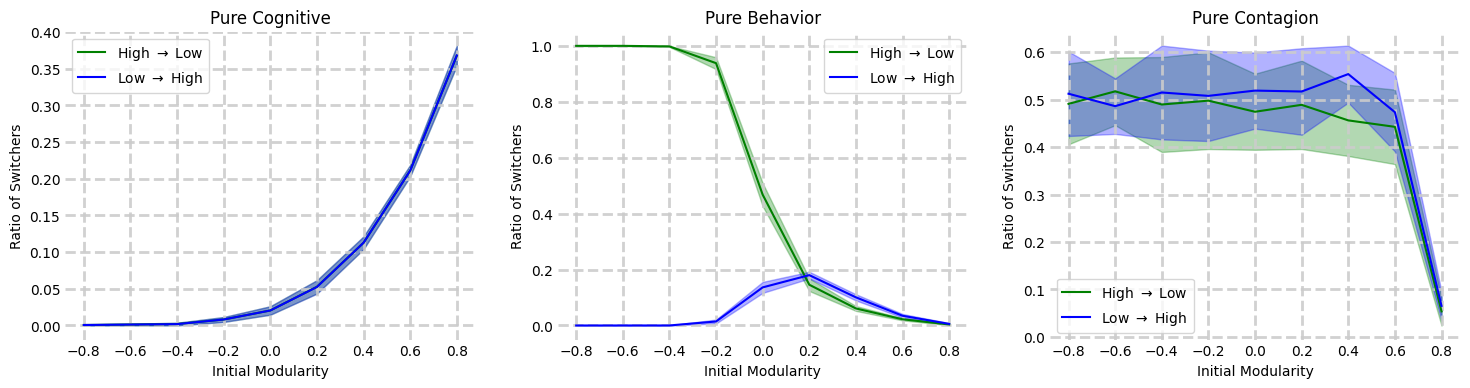

In [ ]:
xaxis = [-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8]
fig, ax = plt.subplots(1,3,figsize=(18,4))
for idx, point in enumerate(defector_data):
    ones_mean = np.array([np.mean(defector_data[point][x]["ones"]) for x in xaxis])
    zeros_mean = np.array([np.mean(defector_data[point][x]["zeros"]) for x in xaxis])
    ones_std = np.array([np.std(defector_data[point][x]["ones"]) for x in xaxis])
    zeros_std = np.array([np.std(defector_data[point][x]["zeros"]) for x in xaxis])

    ax[idx].plot(xaxis, ones_mean, label=r"High $\rightarrow$ Low", color="green")
    ax[idx].plot(xaxis, zeros_mean, label=r"Low $\rightarrow$ High", color="blue")
    ax[idx].fill_between(xaxis, ones_mean-ones_std, ones_mean+ones_std, alpha=0.3, color="green")
    ax[idx].fill_between(xaxis, zeros_mean-zeros_std, zeros_mean+zeros_std, alpha=0.3, color="blue")

    ax[idx].set_title(point_dict[point])
    ax[idx].set_ylabel("Ratio of Switchers")
    ax[idx].set_xlabel("Initial Modularity")
    ax[idx].legend()

    gf.set_frame(ax[idx])

## How does assortativity change, initial vs end

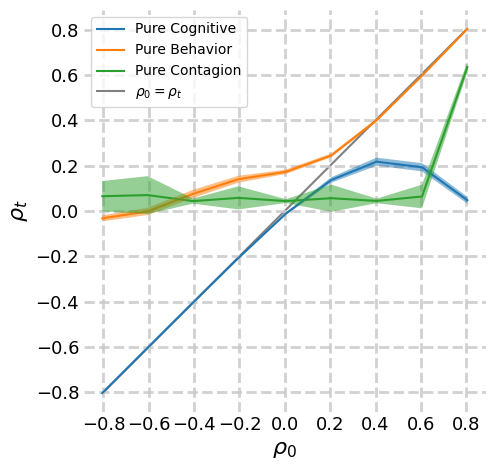

In [ ]:
fig, ax = plt.subplots(1, 1)

pearsons = {}
for row_id, point in enumerate(conf["points"][0]):
    # for column_id, point in enumerate(row):
    model_path = f"p{'-'.join(str(np.round(p,2)) for p in point)}_b{conf['beta']}_sd{conf['sim_dur']}"
    point = str(point)
    pearsons.setdefault(point, {"x": [], "y": [], "std": []})
    patches = []
    for a in conf["a_s"]:
        dyn_data_path = os.path.join(
            conf["base_path"], conf["raw_data"], conf["dyn_path"], conf_path, str(a), model_path
        )

        x, y = [], []
        for idx, file in enumerate(os.listdir(dyn_data_path)):
            # Opening JSON file
            with open(os.path.join(dyn_data_path, file), "r") as f:
                d = json.load(f)
                x.append(d["pearsons"][0])
                y.append(d["pearsons"][-1])
        # x = np.array(x)
        # y = np.array(y)
        pearsons[point]["x"].append(np.mean(x))
        pearsons[point]["y"].append(np.mean(y))
        pearsons[point]["std"].append(np.std(y))

    ax.plot(pearsons[point]["x"], pearsons[point]["y"], label=f"{point_dict[str(point)]}")
    ax.fill_between(
        pearsons[point]["x"],
        np.array(pearsons[point]["y"]) - np.array(pearsons[point]["std"]),
        np.array(pearsons[point]["y"]) + np.array(pearsons[point]["std"]),
        zorder=10,
        alpha=0.5,
    )

diagonal = np.linspace(-.8, .8, 40)
plt.plot(diagonal, diagonal, color="gray", zorder=-10, label=r"$\rho_0=\rho_t$")

plt.legend()
gf.set_frame(ax=ax)
ax.set_box_aspect(1)
set_labels_and_titles(
    ax=ax,
    title=f"",
    xlabel=r"$\rho_0$",
    ylabel=r"$\rho_t$",
    tick_size=13,
    label_size=16,
    title_size=18,
)
plt.tight_layout()
plt.show()


## $e_i, e_j$ scatterplots over time (appendix)

In [ ]:
Gs = []
for yidx, point in enumerate([[1,0,0],[0,1,0],[0,0,1]]):
    G_row = []
    model_path = f"p{'-'.join(str(np.round(p,2)) for p in point)}_b{conf['beta']}_sd{conf['sim_dur']}"
    t0_assort_dir_path = os.path.join(
                    "input", conf["t0_path"], conf_path, str(.4)
                )
    files = os.listdir(t0_assort_dir_path)
    G = nx.read_gml(os.path.join(t0_assort_dir_path, files[0]))
    G_row.append(G.copy())
    model_parameters = {"G": G.copy(), "h": 0.05, "beta": 1 / 2, "point": point}
    model = mainModel(**model_parameters)
    for t in range(10_000+1):
        if t%1_000 == 0:
            print(t)
        model.next()
        if t in [100, 1_000, 10_000]:
            G_row.append(model.G.copy())
    Gs.append(G_row)

def set_colors(n1, n2):
    if (n1[0] == "0") and (n2[0] == "0"):
        return "#443D83"
    elif (n1[0] == "0") and (n2[0] == "1"):
        return "#8073F5"
    elif (n1[0] == "1") and (n2[0] == "1"):
        return "#406923"
    elif (n1[0] == "1") and (n2[0] == "0"):
        return "#8DE84D"
    else:
        return "#000000"

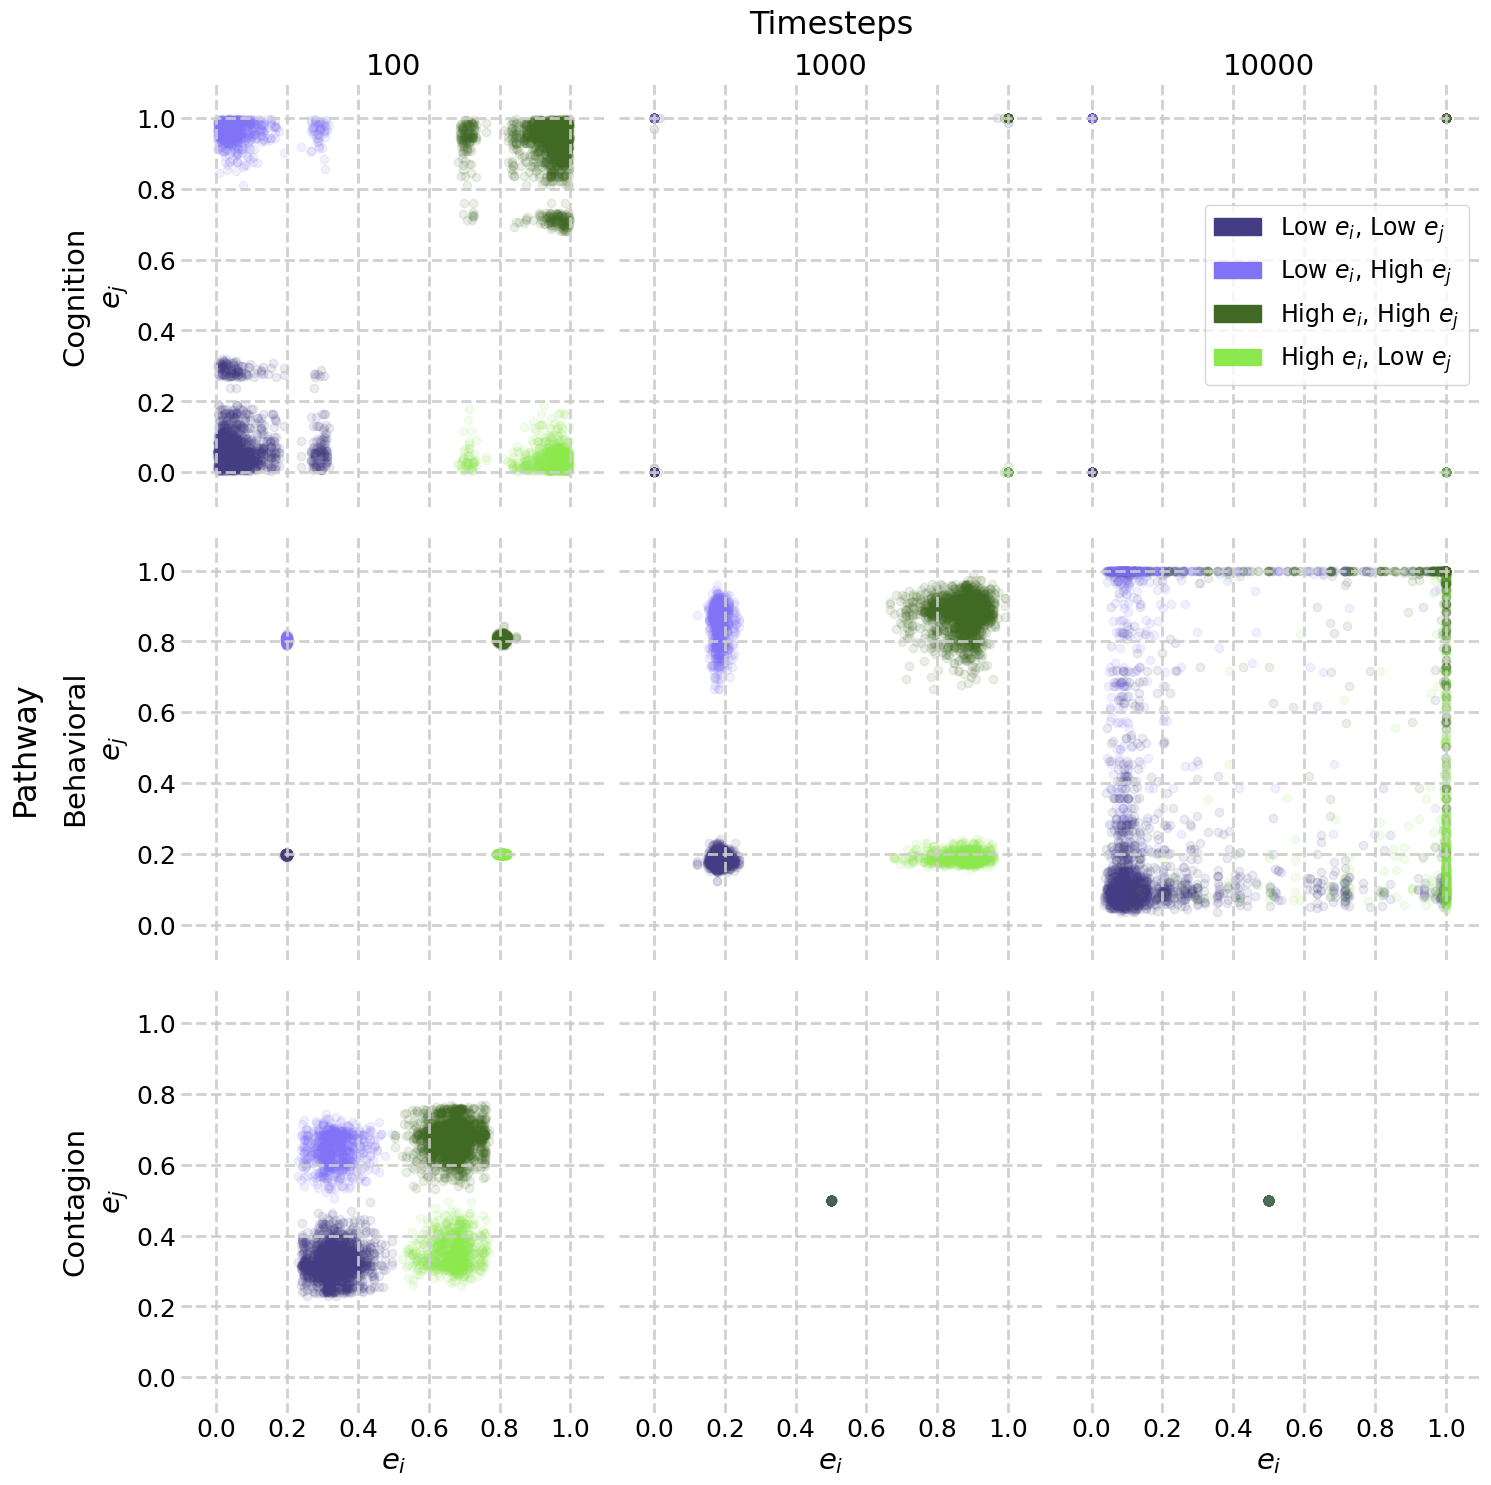

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(15,15), sharey=True, sharex=True)
for yidx, point in enumerate([[1,0,0],[0,1,0],[0,0,1]]):
    cmap_s = plt.get_cmap("viridis")

    labels = [100,1_000,10_000]
    for idx, G in enumerate(Gs[yidx][1:]):
        edges = np.array(G.edges)
        for edge in np.random.choice(range(len(edges)), len(edges)//2, replace=False):
            edge = edges[edge]
            ax[yidx, idx].scatter(G.nodes[edge[0]]["e"], G.nodes[edge[1]]["e"], color=set_colors(edge[0], edge[1]), alpha=0.1)
        ax[yidx, idx].set_ylim(-.1,1.1)
        ax[yidx, idx].set_xlim(-.1,1.1)
        gf.set_frame(ax=ax[yidx, idx])
        label_size = 21
        title_size = 21
        tick_size = 18
        if yidx == 0 and idx == 0:
            set_labels_and_titles(
                ax=ax[yidx, idx],
                title=f"{labels[idx]}",
                xlabel=r"",
                ylabel=rf"$e_j$",    
                tick_size=tick_size,
                label_size=label_size,
                title_size=title_size,
            )
        elif yidx == 0:
            set_labels_and_titles(
                ax=ax[yidx, idx],
                title=f"{labels[idx]}",
                xlabel=r"",
                ylabel=r"",    
                tick_size=tick_size,
                label_size=label_size,
                title_size=title_size,
            )
        elif yidx == 1 and idx == 0:
            set_labels_and_titles(
                ax=ax[yidx, idx],
                title=f"",
                xlabel=r"",
                ylabel=r"$e_j$",    
                tick_size=tick_size,
                label_size=label_size,
                title_size=title_size,
            )
        elif yidx == 1:
            set_labels_and_titles(
                ax=ax[yidx, idx],
                title=f"",
                xlabel=r"",
                ylabel=r"",    
                tick_size=tick_size,
                label_size=label_size,
                title_size=title_size,
            )
        elif yidx == 2 and idx == 0:
            set_labels_and_titles(
                ax=ax[yidx, idx],
                title=f"",
                xlabel=r"$e_i$",
                ylabel=r"$e_j$",    
                tick_size=tick_size,
                label_size=label_size,
                title_size=title_size,
            )
        elif yidx == 2:
            set_labels_and_titles(
                ax=ax[yidx, idx],
                title=f"",
                xlabel=r"$e_i$",
                ylabel=r"",    
                tick_size=tick_size,
                label_size=label_size,
                title_size=title_size,
            )
        ax[yidx, idx].set_box_aspect(1)
patches = [
    mpatches.Patch(color="#443D83", label=r"Low $e_i$, Low $e_j$"),
    mpatches.Patch(color="#8073F5", label=r"Low $e_i$, High $e_j$"),
    mpatches.Patch(color="#406923", label=r"High $e_i$, High $e_j$"),
    mpatches.Patch(color="#8DE84D", label=r"High $e_i$, Low $e_j$")
]
ax[0,2].legend(handles=patches, prop={'size': 17})
rows = ['Cognition', 'Behavioral', 'Contagion']
pad = 5 # in points
ax[0,1].annotate("Timesteps", xy=(0.5, 1.1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=23, ha='center', va='baseline')
for axis, row in zip(ax[:,0], rows):
    axis.annotate(row, xy=(0, 0.5), xytext=(-axis.yaxis.labelpad - pad, 0),
                xycoords=axis.yaxis.label, textcoords='offset points',
                size=21, ha='right', va='center', rotation = 90)
    
ax[1,0].annotate("Pathway", xy=(-1.7, 0.5), xytext=(-ax[1,0].yaxis.labelpad - pad, 0),
                xycoords=ax[1,0].yaxis.label, textcoords='offset points',
                size=23, ha='right', va='center', rotation = 90)
plt.tight_layout()
# plt.savefig("./results/energies_half.png", dpi=300)
plt.show()

## Homophily explanation

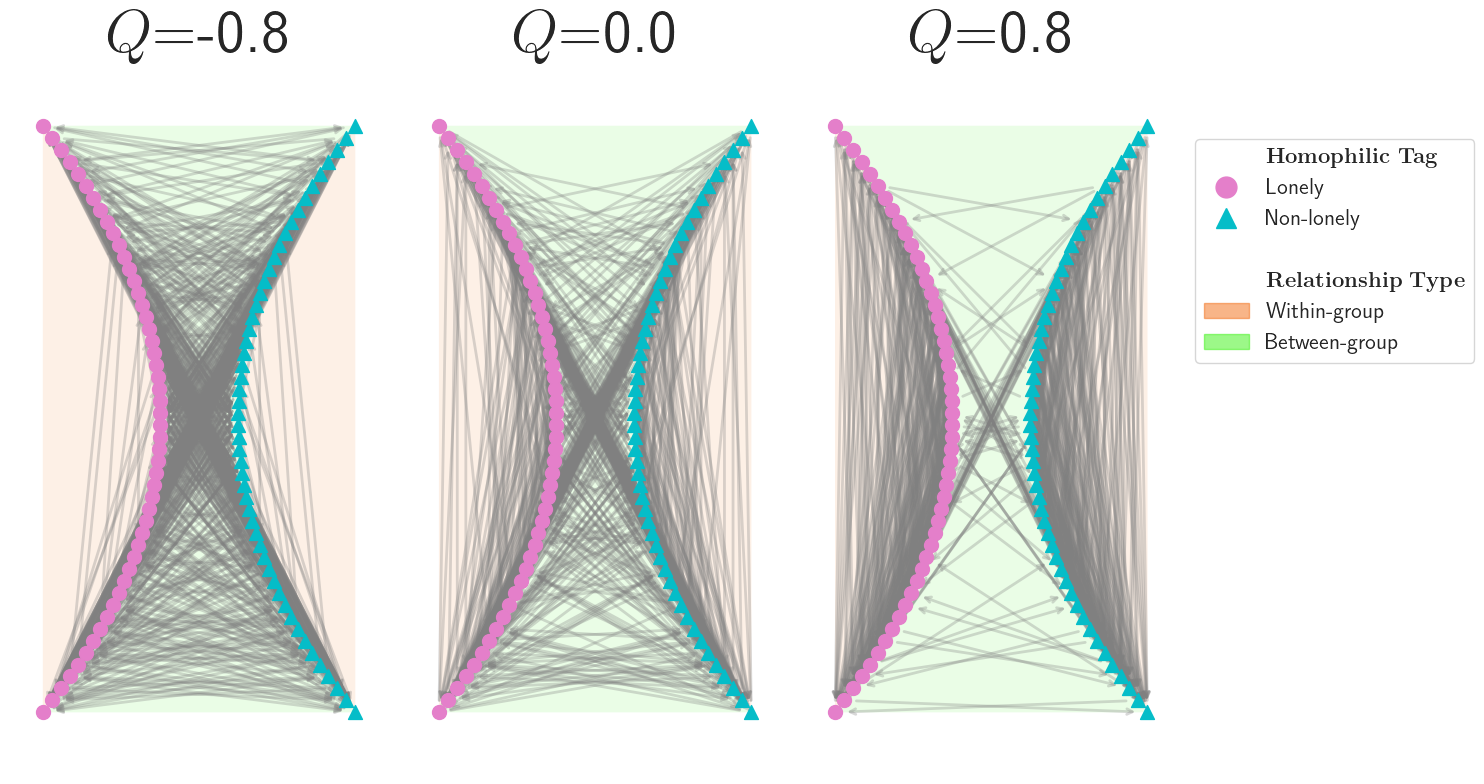

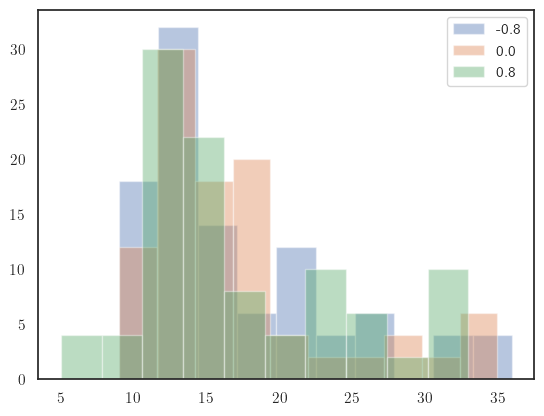

In [815]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch


def plot_fig(ax, G, group_nodes, shapes, colors):
    groups = list(group_nodes.keys())
    subgraphs = {g: G.subgraph(group_nodes[g]) for g in group_nodes}
    pos = {}
    locss = []
    for group, sG in subgraphs.items():
        n_nodes = len(sG.nodes())
        x = [x**2 for x in np.linspace(-3, 3, n_nodes)]
        if group == groups[0]:
            locs = [(-5-x[i], y)
                    for i, y in enumerate(np.linspace(1, 0, n_nodes))]
        else:
            locs = [(1+x[i], y)
                    for i, y in enumerate(np.linspace(1, 0, n_nodes))]
        od = np.array(sG.degree())
        sd = {}
        for idx, node in enumerate(np.argsort([int(node[1]) for node in od])):
            pos[od[node][0]] = list(locs[idx])
            sd[od[node][0]] = int(od[node][1])*10
        sizes = [sd[node] for node in sG.nodes]

        path = Path(locs)
        patch = PathPatch(path, facecolor='#F26C13', alpha=0.1)
        ax.add_patch(patch)
        locss.append(locs)

        nx.draw_networkx_nodes(
            sG, pos=pos, node_color=colors[group], node_shape=shapes[group], node_size=100, ax=ax)

    locs = locss[0]
    for l in locss[1][::-1]:
        locs.append(l)

    path = Path(locs)
    patch = PathPatch(path, facecolor='#3AF213', alpha=0.1)
    ax.add_patch(patch)

    nx.draw_networkx_edges(G, pos=pos, arrows=True, arrowstyle='->', connectionstyle="arc3,rad=0.",
                           edge_color="gray", alpha=0.3, width=2, ax=ax)
    # Remove box around figure
    for spine in ("top", "right", "bottom", "left"):
        ax.spines[spine].set_visible(False)


cmap = plt.get_cmap("tab10")
a_s = [-.8, 0.0, 0.8]
Gs = []
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
for i, a in enumerate(a_s):
    g_dir = os.path.join(
        "input/t0_graphs/barabasi_albert-[0.2, 0.8]es-50n-11p", str(a))
    files = os.listdir(g_dir)
    Gs.append(nx.read_gml(os.path.join(g_dir, files[2])))
    groups = set([node[0] for node in Gs[-1].nodes])
    group_nodes = {g: [node for node in Gs[-1].nodes if node[0] == g]
                   for g in groups}

    shapes = {"0": "o", "1": "^"}
    colors = {"0": "#E47FCA", "1": "#05BDC8"}

    plot_fig(axs[i], Gs[-1], group_nodes, shapes, colors)
    axs[i].set_title(rf"$Q$={a}", size=44)
# patches = [mpatches.Patch(color="#3AF213", label="Within-group", alpha=0.5),
#            mpatches.Patch(color="#F26C13", label="Between-group",alpha=0.5)]
# axs[2].legend(handles=patches, prop={'size': 16}, bbox_to_anchor=(
#     1.01, .91), title=r"Relation Type", title_fontsize=18)


# patches = [mpatches.Patch(color="#E47FCA", label="Lonely", shapes="o", linewidth=0, alpha=0.5), 
#            mpatches.Patch(color="#05BDC8", label="Non-lonely", shapes="^", linewidth=0, alpha=0.5)]
# axs[2].legend(handles=patches, prop={'size': 16}, bbox_to_anchor=(
#     1.01, .71), title=r"Homophilic Trait", title_fontsize=18)
shapes = {"0": "o", "1": "^"}
colors = {"0": "#E47FCA", "1": "#05BDC8"}
titles = {"0": "Lonely", "1": "Non-lonely"}

from matplotlib.patches import Rectangle

legend = [Rectangle((0, 0), 1, 1, fc="w", fill=False, label=r"$\bf{Homophilic\ Tag}$", edgecolor='none', linewidth=0)]
for i,a in enumerate(colors):
    legend.append(mlines.Line2D([], [], color=colors[a], label=titles[a], marker=shapes[str(i)],linestyle='None', markersize=15))
legend.append(Rectangle((0, 0), 1, 1, fc="w", fill=False, label="", edgecolor='none', linewidth=0))
legend.append(Rectangle((0, 0), 1, 1, fc="w", fill=False, label=r"$\bf{Relationship\ Type}$", edgecolor='none', linewidth=0))
legend.append(mpatches.Patch(color="#F26C13", label="Within-group",alpha=0.5))
legend.append(mpatches.Patch(color="#3AF213", label="Between-group", alpha=0.5))

axs[2].legend(handles=legend, prop={'size': 16}, bbox_to_anchor=(1.01, .91), title="", title_fontsize=18)
plt.tight_layout()
plt.savefig("output/final_results/modularity.png", dpi=300)
plt.show()

for i, G in enumerate(Gs):
    plt.hist([n[1] for n in G.degree()], alpha=0.4, label=a_s[i])
plt.legend()
plt.show()

## Noise assessment

TODO:
- Check if DOS changes
- Check if timeseries change significantly
  - Do statistics on comparing timeseries?
- Check if ratio of group changers changes?

In [ ]:
def check_changers(G):
    changers = {"ones":[], "zeros":[]}
    zeros = np.array([G.nodes[node]["e"] for node in G.nodes if node[0] == "0"])
    ones = np.array([G.nodes[node]["e"] for node in G.nodes if node[0] == "1"])
    changers["zeros"].append(len(zeros[zeros>0.5])/len(zeros))
    changers["ones"].append(len(ones[ones<0.5])/len(ones))
    return changers

In [ ]:
conf["a_s"] = [-.8, -.6, -.4, -.2, 0, .2, .4, .6, .8]
comparisons = ["", "noise_01"]
c_keys = ["0.02", "0.1"]
sim_dur = 1000
noise_data = {}
for idx, c in enumerate(comparisons):
    conf["sim_dur"] = sim_dur
    noise_data.setdefault(c_keys[idx], {})
    points = [[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]]
    # fig, ax = plt.subplots(1,1,figsize=(6,4))
    for point in points:
        noise_data[c_keys[idx]].setdefault(str(point), {})
        for a in conf["a_s"]:
            noise_data[c_keys[idx]][str(point)].setdefault(a, {})
            noise_data[c_keys[idx]][str(point)][a].setdefault("DOS", [])
            noise_data[c_keys[idx]][str(point)][a].setdefault("CC", [])

            model_path = f"p{'-'.join(str(np.round(p,2)) for p in point)}_b{conf['beta']}_sd{conf['sim_dur']}"
            dir_path = os.path.join(
                conf["base_path"], conf["raw_data"], c, conf["tt_path"], conf_path, str(a), model_path
            )
            files = os.listdir(dir_path)

            for file in files:
                G = nx.read_gml(os.path.join(dir_path, file))
                noise_data[c_keys[idx]][str(point)][a]["DOS"].append(get_DOS(G))
                noise_data[c_keys[idx]][str(point)][a]["CC"].append(check_changers(G))


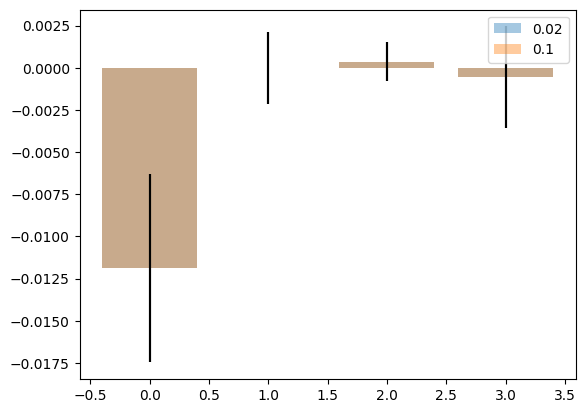

In [ ]:
for noise in noise_data:
    nd = []
    for run in noise_data["0.02"]["[1.0, 0.0, 0.0]"][0.0]["DOS"]:
        nd.append([run[i] for i in range(1,5)])
    nd = np.array(nd)
    plt.bar([i for i in range(4)], np.mean(nd, axis=0), yerr=np.std(nd, axis=0), alpha=0.4, label=noise)
plt.legend()
plt.show()


In [ ]:
points = ["[1.0,0.0,0.0]","[0.0,1.0,0.0]","[0.0,0.0,1.0]"]
for point in points:
    noises = noise_data.keys()
    for noise in noises:
        noise_data[noise][point][0.8]["CC"]

KeyError: '[1.0,0.0,0.0]'

In [ ]:
# function to add two numbers


## Rearrange data structure

In [ ]:
for sd in [100, 1000]:
    for a in conf["a_s"]:
        for types in ["tt_graphs", "dyn_data"]:
            model_path = f"noise_{noise}-b{conf['beta']}-sd{sd}"
            base = os.path.join("output/raw_data/final_data/", conf_path, model_path)
            base_plus_type = os.path.join(base, types)
            os.mkdir(os.path.join(base_plus_type, str(a)))
    

In [ ]:

import shutil
a = 0.8
test_folder = "test_testy"
model_path = f"noise_{noise}-b{conf['beta']}-sd{conf['sim_dur']}"
base = os.path.join("output/raw_data/final_data/", conf_path, model_path)
base_plus_type = os.path.join(base, conf["tt_path"])
base_plus_type_plus_a = os.path.join(base_plus_type, str(a))

testy_path = os.path.join(base_plus_type_plus_a, test_folder)

new_model_path = f"noise_{noise}-b{conf['beta']}-sd{100}"
new_base = os.path.join("output/raw_data/final_data/", conf_path, new_model_path)
new_base_plus_type = os.path.join(new_base, conf["tt_path"])
new_base_plus_type_plus_a = os.path.join(new_base_plus_type, str(a))
new_testy_path = os.path.join(new_base_plus_type_plus_a, test_folder.split("_")[0])

shutil.move(testy_path, new_testy_path)

In [ ]:
base = os.path.join("output/raw_data/final_data/", conf_path, model_path)
base_new = os.path.join("output/raw_data/final_data/", conf_path)

sds = [100, 1000, 10000]
for types in ["tt_graphs", "dyn_data"]:
    base_plus_type = os.path.join(base, types)
    for a in conf["a_s"]:
        base_plus_type_plus_a = os.path.join(base_plus_type, str(a))
        folders = os.listdir(base_plus_type_plus_a)
        for folder in folders:
            for sd in sds:
                if folder.split("_")[-1][2:] == str(sd):
                    new_model_path = f"noise_{noise}-b{conf['beta']}-sd{sd}"
                    new_base = os.path.join(base_new, new_model_path)
                    new_base_plus_type_plus_a = os.path.join(
                        new_base, types, str(a), folder.split("_")[0])
                    old = os.path.join(base_plus_type_plus_a, folder)
                    new = os.path.join(new_base_plus_type_plus_a)
                    shutil.move(old, new)

# Check if simulation lengths worked out

In [604]:
base = "/Users/chatel/github/Paper repos/Loneliness_Clustering/output/raw_data/final_data/barabasi_albert-[0.2, 0.8]es-500n-11p"
sds = [100, 1000, 10000]
for point in points:
    point = f"p{'-'.join(str(np.round(p,2)) for p in point)}"
    for s in sds:
        f = open(os.path.join(base, f"noise_0.02-b0.5-sd{s}/dyn_data/0.8/{point}/0.json"))
            
        # returns JSON object as 
        # a dictionary
        dos_data = json.load(f)
        print(s, point, len(dos_data['non_lonely_mean']))

100 p1.0-0.0-0.0 100
1000 p1.0-0.0-0.0 1000
10000 p1.0-0.0-0.0 10000
100 p0.0-1.0-0.0 100
1000 p0.0-1.0-0.0 1000
10000 p0.0-1.0-0.0 10000
100 p0.0-0.0-1.0 100
1000 p0.0-0.0-1.0 1000
10000 p0.0-0.0-1.0 10000


# Noise

## Check timeseries

In [ ]:
from networkx.exception import NetworkXError
def replace_brackets(string):
    return string.replace("[", "").replace("]", "")

noises = [0.02, 0.1]
conf["a_s"] = [.4, .6, .8]
conf["points"] = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]

for noise in noises:
    conf_path = f"{conf['network_gen_fn'].__name__}-{conf['e_samples']}es-500n-{conf['p_rel']}p"
    for point in conf["points"]:
        for a in conf["a_s"]:
            model_path = f"noise_{noise}-b{conf['beta']}-sd10000"
            dir_path = os.path.join("output/raw_data/final_data/", conf_path, model_path, "dyn_data", str(a), f"p{replace_brackets(str(point)).replace(', ', '-')}"
            )
            files = os.listdir(dir_path)
            # Opening JSON file

            f = open(os.path.join(dir_path, files[0]))
                
            # returns JSON object as 
            # a dictionary
            dos_data = json.load(f)
            plt.plot(dos_data["non_lonely_mean"], label={a})
            plt.plot(dos_data["lonely_mean"])
        plt.title(f"noise {noise}, point {point}")
        plt.show()


## Check DOI

In [731]:
from networkx.exception import NetworkXError
def replace_brackets(string):
    return string.replace("[", "").replace("]", "")

noises = [0.02, 0.1]
conf["a_s"] = [.4, .6, .8]
conf["points"] = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
all_data_noise = {}

conf_path = f"{conf['network_gen_fn'].__name__}-{conf['e_samples']}es-500n-{conf['p_rel']}p"
for a in conf["a_s"]:
    all_data_noise.setdefault(a, {})
    for point in conf["points"]:
        all_data_noise[a].setdefault(replace_brackets(str(point)), {})
        bar_data = {}
        for noise in noises:
            bar_data.setdefault(noise, {})
            model_path = f"noise_{noise}-b{conf['beta']}-sd10000"
            dir_path = os.path.join("output/raw_data/final_data/", conf_path, model_path, "tt_graphs", str(a), f"p{replace_brackets(str(point)).replace(', ', '-')}"
            )
            files = os.listdir(dir_path)
            for f in files:
                G = nx.read_gml(os.path.join(dir_path, f))
                dc = get_DOS(G)
                for d in dc:
                    bar_data[noise].setdefault(d, [])
                    bar_data[noise][d].append(dc[d])
        all_data_noise[a][replace_brackets(str(point))] = bar_data


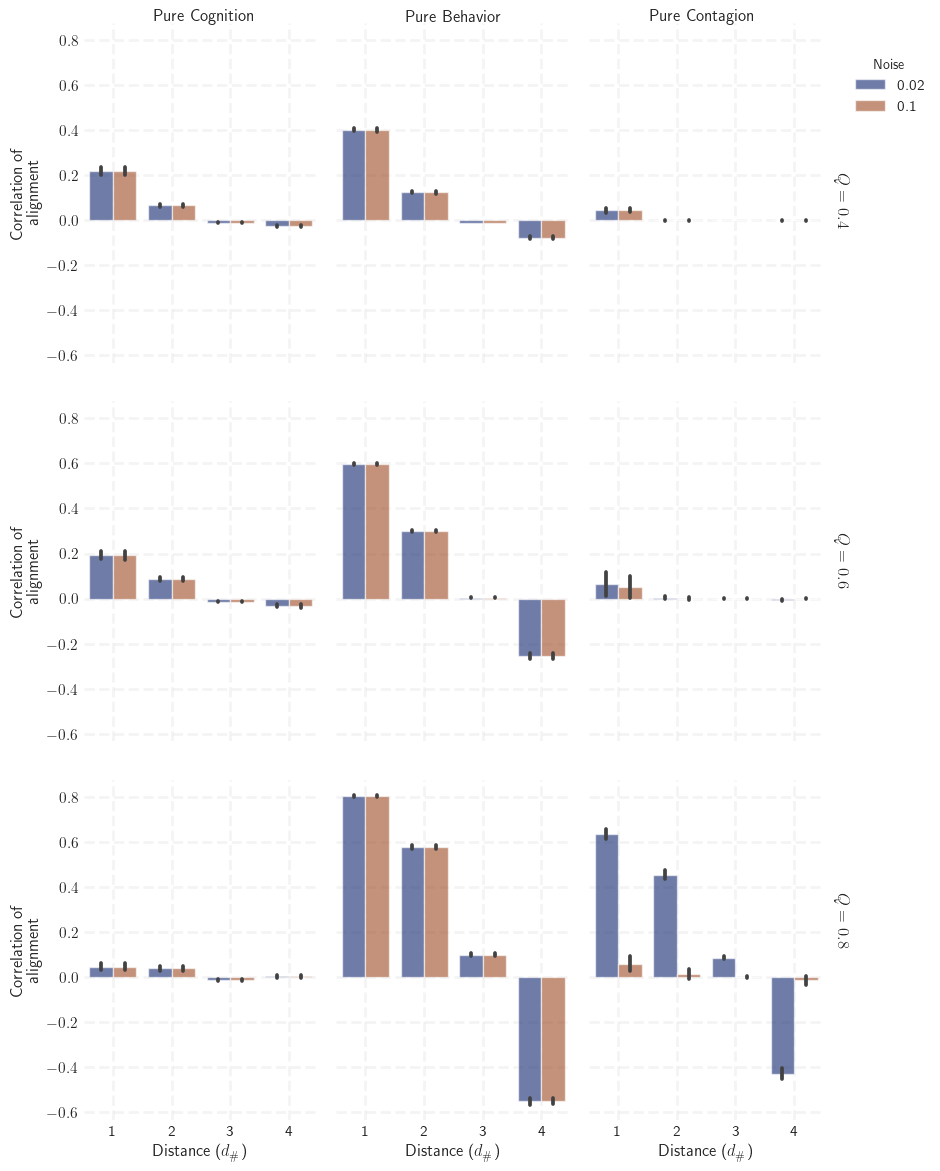

In [794]:
import seaborn as sns
sns.set_theme(style="white")

df = {"noise": [], "degree": [], "c": [], "a": [], "point": []}
for row, a in enumerate(all_data_noise):
    for col, point in enumerate(all_data_noise[a]):
        bar_data = all_data_noise[a][point]
        for noise in noises:
            for degree in bar_data[noise]:
                for c in bar_data[noise][degree]:
                    df["noise"].append(noise)
                    df["degree"].append(degree)
                    df["c"].append(c)
                    df["a"].append(a)
                    df["point"].append(point)

df_data = pd.DataFrame(df)

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_data, kind="bar",
    x="degree", y="c", hue="noise",
    errorbar="sd", palette="dark", alpha=.6, height=4, aspect=0.7, row="a", col="point"
)
g.despine(left=True)
g.set_axis_labels(r"Distance ($d_\#$)", "Correlation of\nalignment")
g.set_titles(template="", y=0.85)
g.legend.set_title(f"Noise", prop={'size': 10})
g.fig.text(0.23, 0.97, r"Pure Cognition", ha='center')
g.fig.text(0.5, 0.97, r"Pure Behavior", ha='center')
g.fig.text(0.77, 0.97, r"Pure Contagion", ha='center')
g.fig.text(0.92, 0.2, r"$Q=0.8$", ha='center', rotation=-90)
g.fig.text(0.92, 0.5, r"$Q=0.6$", ha='center', rotation=-90)
g.fig.text(0.92, 0.8, r"$Q=0.4$", ha='center', rotation=-90)
sns.move_legend(g, "upper left", bbox_to_anchor=(0.92, 0.95))
for (row_val, col_val), ax in g.axes_dict.items():
    gf.set_frame(ax, major_alpha=0.2)
g.savefig("output/final_results/noise_comparison.png", dpi=300, bbox_inches='tight')

# Size effect

## Check if sizes are actually right

In [596]:
base = "/Users/chatel/github/Paper repos/Loneliness_Clustering/output/raw_data/final_data/"
sizes = [50, 500, 1000, 5000]
for point in points:
    point = f"p{'-'.join(str(np.round(p,2)) for p in point)}"
    for s in sizes:
        sim = f"barabasi_albert-[0.2, 0.8]es-{s}n-11p"
        files = os.listdir(os.path.join(base, sim, f"noise_0.02-b0.5-sd10000/tt_graphs/0.8/{point}"))
        G = nx.read_gml(os.path.join(base, sim, f"noise_0.02-b0.5-sd10000/tt_graphs/0.8/{point}/{files[0]}"))
        print(s, len(G.nodes), point)

50 100 p1.0-0.0-0.0
500 1000 p1.0-0.0-0.0
1000 2000 p1.0-0.0-0.0
5000 10000 p1.0-0.0-0.0
50 100 p0.0-1.0-0.0
500 1000 p0.0-1.0-0.0
1000 2000 p0.0-1.0-0.0
5000 10000 p0.0-1.0-0.0
50 100 p0.0-0.0-1.0
500 1000 p0.0-0.0-1.0
1000 2000 p0.0-0.0-1.0
5000 10000 p0.0-0.0-1.0


# Check effect of size

In [635]:
from networkx.exception import NetworkXError


def replace_brackets(string):
    return string.replace("[", "").replace("]", "")


sizes = [50, 500, 1000, 5000]
conf["noise"] = 0.02
conf["sim_dur"] = 10000
conf["a_s"] = [.4, .6, .8]
conf["points"] = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
all_data = {}

for a in conf["a_s"]:
    all_data.setdefault(a, {})
    for point in conf["points"]:   
        all_data[a].setdefault(replace_brackets(str(point)), {})
        # fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        bar_data = {}
        for size in sizes:
            bar_data.setdefault(size, {})
            conf_path = f"{conf['network_gen_fn'].__name__}-{conf['e_samples']}es-{size}n-{conf['p_rel']}p"
            model_path = f"noise_{conf['noise']}-b{conf['beta']}-sd{conf['sim_dur']}"
            dir_path = os.path.join("output/raw_data/final_data/", conf_path, model_path, conf["tt_path"], str(a), f"p{replace_brackets(str(point)).replace(', ', '-')}"
                                    )
            files = os.listdir(dir_path)
            for f in files:
                G = nx.read_gml(os.path.join(dir_path, f))
                dc = get_DOS(G)
                for d in dc:
                    bar_data[size].setdefault(d, [])
                    bar_data[size][d].append(dc[d])
        all_data[a][replace_brackets(str(point))] = bar_data
        

In [721]:
with open("output/processed_data/json_data/size_comparison.json", "w") as outfile:
    json.dump(all_data, outfile)

In [722]:
# Opening JSON file
f = open('output/processed_data/json_data/size_comparison.json')
    
# returns JSON object as 
# a dictionary
dos_data = json.load(f)

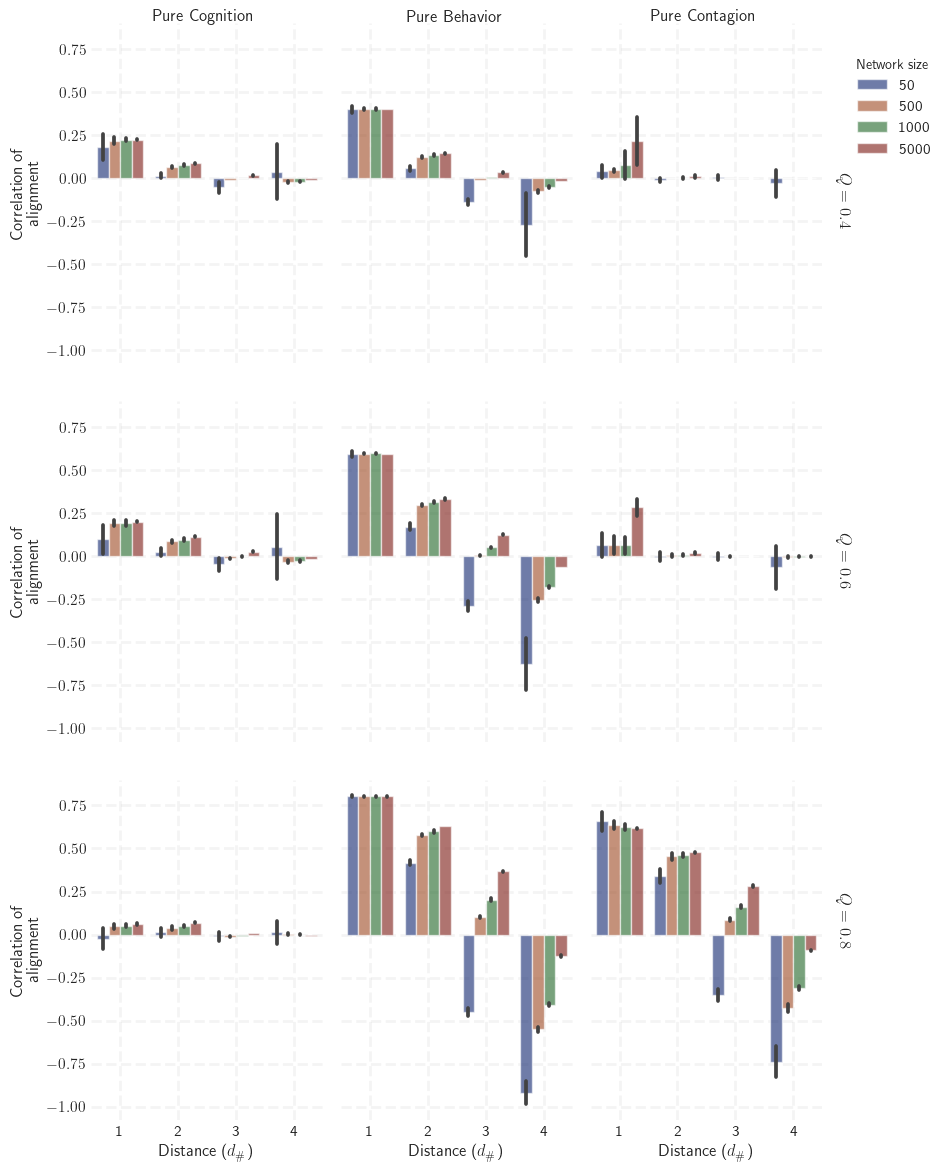

In [795]:
import seaborn as sns
sns.set_theme(style="white")

df = {"size": [], "degree": [], "c": [], "a": [], "point": []}
for row, a in enumerate(all_data):
    for col, point in enumerate(all_data[a]):
        bar_data = all_data[a][point]
        for size in sizes:
            for degree in bar_data[size]:
                for c in bar_data[size][degree]:
                    df["size"].append(size)
                    df["degree"].append(degree)
                    df["c"].append(c)
                    df["a"].append(a)
                    df["point"].append(point)

df_data = pd.DataFrame(df)

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_data, kind="bar",
    x="degree", y="c", hue="size",
    errorbar="sd", palette="dark", alpha=.6, height=4, aspect=0.7, row="a", col="point"
)
g.despine(left=True)
g.set_axis_labels(r"Distance ($d_\#$)", "Correlation of\nalignment")
g.set_titles(template="", y=0.85)
g.legend.set_title(f"Network size", prop={'size': 10})
g.fig.text(0.23, 0.97, r"Pure Cognition", ha='center')
g.fig.text(0.5, 0.97, r"Pure Behavior", ha='center')
g.fig.text(0.77, 0.97, r"Pure Contagion", ha='center')
g.fig.text(0.92, 0.2, r"$Q=0.8$", ha='center', rotation=-90)
g.fig.text(0.92, 0.5, r"$Q=0.6$", ha='center', rotation=-90)
g.fig.text(0.92, 0.8, r"$Q=0.4$", ha='center', rotation=-90)
sns.move_legend(g, "upper left", bbox_to_anchor=(0.92, 0.95))
for (row_val, col_val), ax in g.axes_dict.items():
    gf.set_frame(ax, major_alpha=0.2)
g.savefig("output/final_results/size_comparison.png", dpi=300, bbox_inches='tight')